## Готовые библиотеки для состязательных атак

In [1]:
import foolbox as fb
import eagerpy as ep
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

## Использование библиотеки Foolbox

In [2]:
model = torchvision.models.resnet18(pretrained=True).eval()

E:\DS\anakonda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\DS\anakonda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = fb.PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

In [4]:
fmodel = fmodel.transform_bounds((0, 1))
assert fmodel.bounds == (0, 1)

In [5]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=20)

In [6]:
print('Точность модели перед атакой: ', fb.utils.accuracy(fmodel, images, labels)*100)

Точность модели перед атакой:  94.9999988079071


#### DeepFoolAttack

In [7]:
attack = fb.attacks.LinfDeepFoolAttack()
images = ep.astensor(images)
labels = ep.astensor(labels)
criterion = fb.criteria.Misclassification(labels)
epsilons = np.linspace(0.0, 0.005, num=20)

In [8]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

In [9]:
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
robust_accuracy

PyTorchTensor(tensor([0.9500, 0.8000, 0.6500, 0.4500, 0.3500, 0.2000, 0.1000, 0.0500, 0.0500,
                      0.0500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                      0.0000, 0.0000], device='cuda:0'))

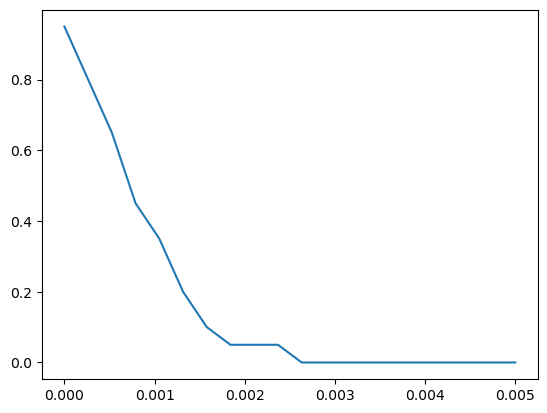

In [11]:
plt.plot(epsilons, robust_accuracy.numpy())

Мы видим, что модель cовершенно не устойчива для состязательных атак. Даже чрезвычайно малых возмущений достаточно, чтобы изменить классификацию.

#### CarliniWagnerAttack (targeted attack)

In [12]:
target_classes = (labels + 200) % 1000
criterion = fb.criteria.TargetedMisclassification(target_classes)
attack = fb.attacks.L2CarliniWagnerAttack(steps=1000)
epsilons = None

In [13]:
advs, _, is_adv = attack(fmodel, images, criterion, epsilons=epsilons)

In [14]:
print('Точность модели после CarliniWagnerAttack:', fb.utils.accuracy(fmodel, advs, labels)*100)

Точность модели после CarliniWagnerAttack: 0.0


### Примеры изображений до и после состязательной атаки

Оригинальные изображения


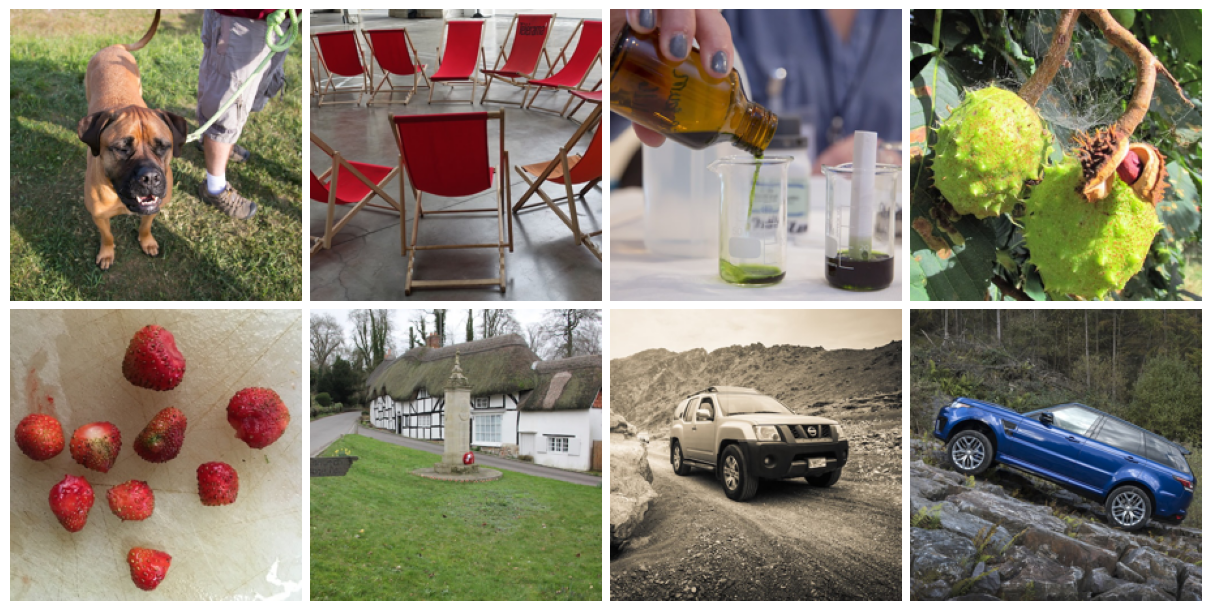

In [15]:
print('Оригинальные изображения')
fb.plot.images(images, n = 8, nrows= 2, scale = 3)

Состязательные примеры


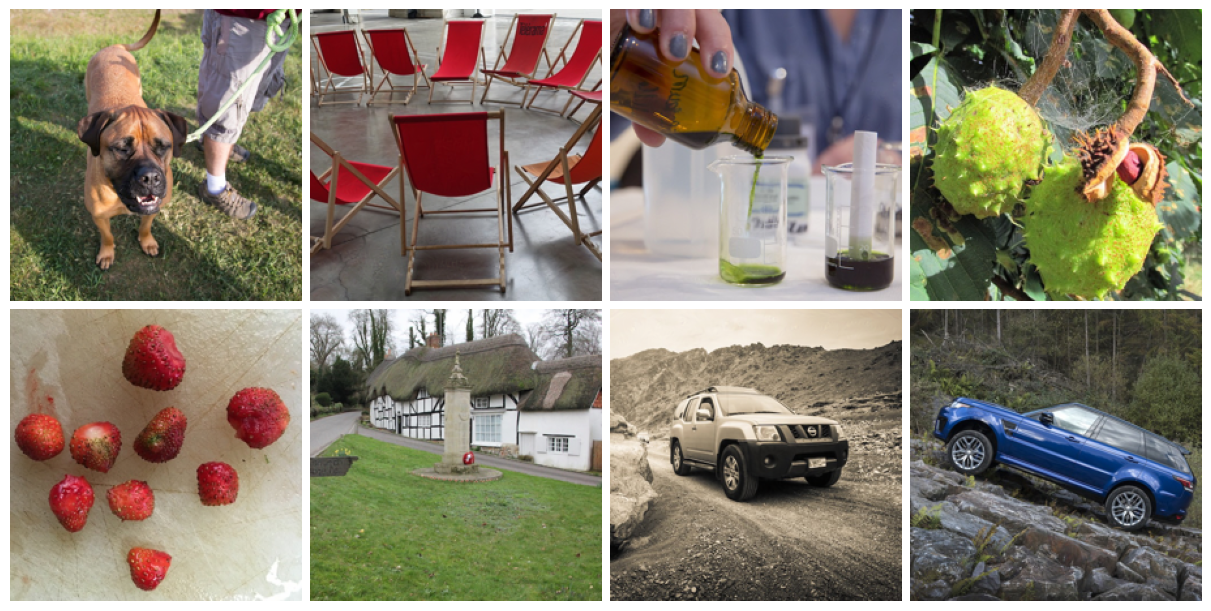

In [16]:
print('Состязательные примеры')
fb.plot.images(advs, n = 8, nrows= 2, scale = 3)

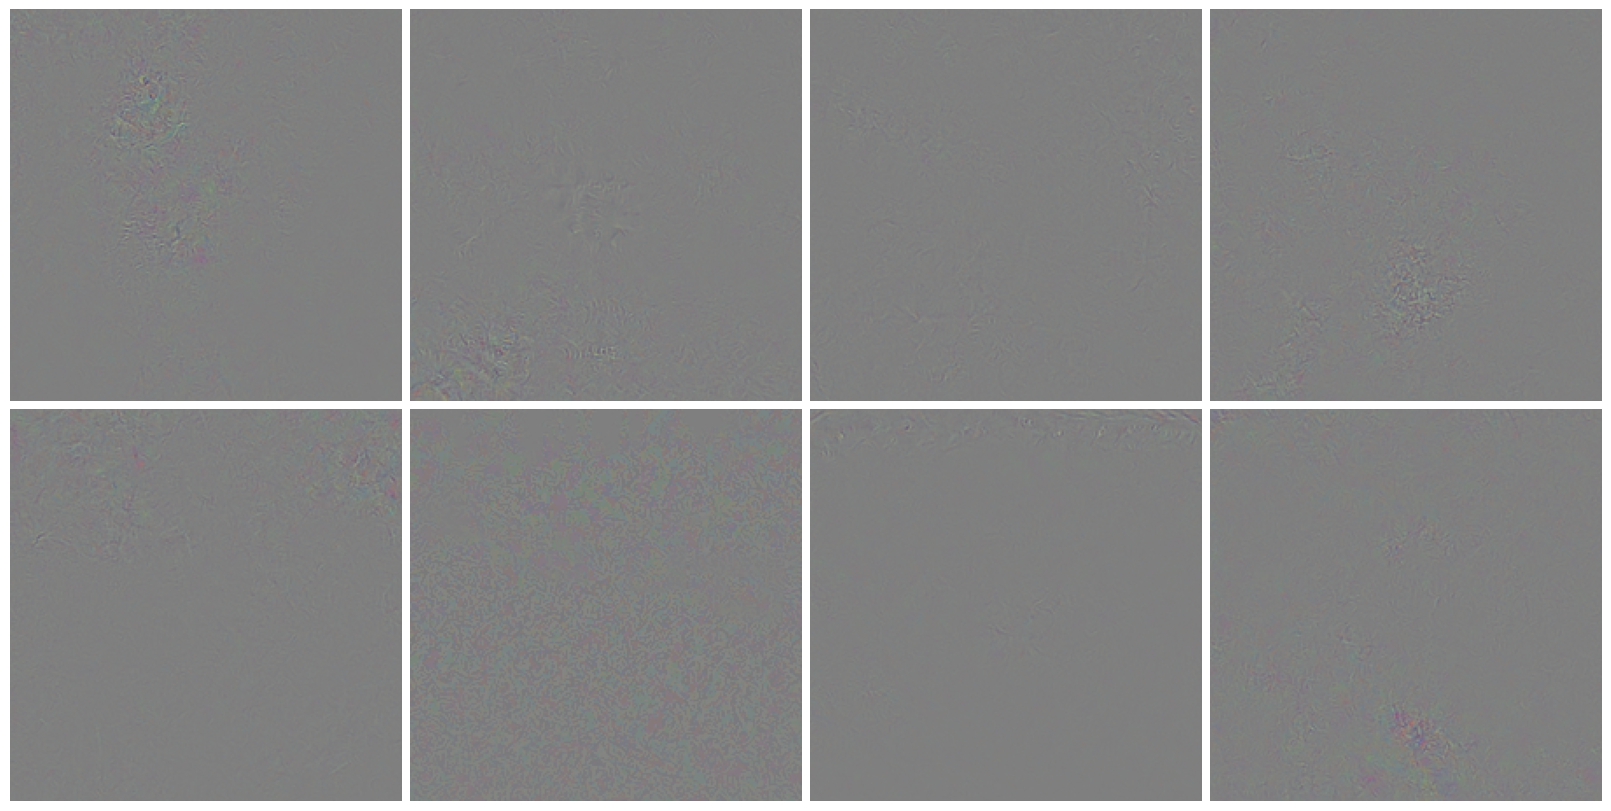

In [17]:
fb.plot.images(advs - images, n = 8, nrows= 2, bounds=(-0.1, 0.1), scale=4.)

Состязательные примеры выглядят как исходные (чистые) изображения. Это показывает, что модель не устойчива к атакам злоумышленников. Небольшие возмущения вводят модель в заблуждение и позволяют злоумышленнику контролировать, какой класс распознается.

### Использование библиотеки Foolbox. Разные атаки и эпсилон

In [18]:
import foolbox.attacks as fa
if __name__ == "__main__":
    # instantiate a model (could also be a TensorFlow or JAX model)
    model = torchvision.models.resnet18(pretrained=True).eval()
    preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
    fmodel = fb.PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

    # get data and test the model
    # wrapping the tensors with ep.astensors is optional, but it allows
    # us to work with EagerPy tensors in the following
    images, labels = ep.astensors(*fb.samples(fmodel, dataset="imagenet", batchsize=16))
    clean_acc = fb.accuracy(fmodel, images, labels)
    print(f"clean accuracy:  {clean_acc * 100:.1f} %")
    print("")

    attacks = [
        fa.FGSM(),
        fa.LinfPGD(),
        fa.LinfBasicIterativeAttack(),
        fa.LinfAdditiveUniformNoiseAttack(),
        fa.LinfDeepFoolAttack(),
    ]

    epsilons = [
        0.0,
        0.0005,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.005,
        0.01,
        0.02,
        0.03,
        0.1,
        0.3,
        0.5,
        1.0,
    ]
    print("epsilons")
    print(epsilons)
    print("")

    attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
    for i, attack in enumerate(attacks):
        _, _, success = attack(fmodel, images, labels, epsilons=epsilons)
        assert success.shape == (len(epsilons), len(images))
        success_ = success.numpy()
        assert success_.dtype == np.bool
        attack_success[i] = success_
        print(attack)
        print("  ", 1.0 - success_.mean(axis=-1).round(2))

    # calculate and report the robust accuracy (the accuracy of the model when
    # it is attacked) using the best attack per sample
    robust_accuracy = 1.0 - attack_success.max(axis=0).mean(axis=-1)
    print("")
    print("-" * 79)
    print("")
    print("worst case (best attack per-sample)")
    print("  ", robust_accuracy.round(2))
    print("")

    print("robust accuracy for perturbations with")
    for eps, acc in zip(epsilons, robust_accuracy):
        print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean accuracy:  93.8 %

epsilons
[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1.0]



C:\Users\cefeu\AppData\Local\Temp\ipykernel_17996\285840194.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
C:\Users\cefeu\AppData\Local\Temp\ipykernel_17996\285840194.py:49: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert success_.dtype == np.bool


LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [0.94 0.81 0.44 0.31 0.25 0.06 0.   0.   0.   0.   0.   0.   0.   0.  ]
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)
   [0.94 0.81 0.38 0.12 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
LinfBasicIterativeAttack(rel_stepsize=0.2, abs_stepsize=None, steps=10, random_start=False)
   [0.94 0.69 0.38 0.12 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
LinfAdditiveUniformNoiseAttack()
   [0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.81 0.38 0.12 0.  ]
LinfDeepFoolAttack(steps=50, candidates=10, overshoot=0.02, loss=logits)
   [0.94 0.75 0.31 0.12 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]

-------------------------------------------------------------------------------

worst case (best attack per-sample)
   [0.94 0.69 0.31 0.12 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]

robust accuracy for perturb

## Испозование библиотеки Adversarial Robustness Toolbox (ART)

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

In [22]:
# Step 0: Define the neural network model, return logits instead of activation in forward method

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Step 2: Create the model

model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on test examples: 97.82%
Accuracy on adversarial test examples: 23.95%
